In [ ]:
#aaaaaaa
from functools import partial

import numpy as np
import pandas as pd
import os
import random
import time
import tensorflow as tf, re, math
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import gc
!pip install uproot
import uproot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 302 kB 30.5 MB/s 


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
    
!nvidia-smi

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Mon Jun 27 13:50:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+----------

In [ ]:
batch_size = 32

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def get_encoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim):
    # Encoder
    encoder_inputs = layers.Input(shape=(original_dim,))
    h = layers.Dense(intermediate_dim_1)(encoder_inputs)
    h = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.2)(h)
    h = layers.Dense(intermediate_dim_2)(h)
    h = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.2)(h)
    z_mu = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    z = Sampling()([z_mu, z_log_var])
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    return encoder  
    
def get_decoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    d = layers.Dense(intermediate_dim_2)(decoder_inputs)
    d = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(d)
    d = layers.BatchNormalization()(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(intermediate_dim_1)(d)
    d = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(d)
    d = layers.BatchNormalization()(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(original_dim, activation='sigmoid')(d)
    decoder = Model(decoder_inputs, d, name="decoder")
    return decoder

class vae(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(vae, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        y_pred = self.decoder(z)
        return y_pred 

In [ ]:
def get_df(test_root, filter_name):
    events = uproot.open(test_root, filter_name=filter_name)["tree"]
    df = events.arrays(library="pd")
    return df

features = []
# variables: general
features += ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', \
             'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', \
             'FatJet_jetId', 'FatJet_lsf3', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', \
            ]

# variables: tau1
features += ['FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', \
             'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', \
             'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', \
            ]

# variables: tau2
features += ['FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', \
             'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', \
             'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', \
            ]

# variables: tau3 and tau4
features += ['FatJet_tau3', 'FatJet_tau4',]

# variables: track
features += ['FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', \
             'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', \
             'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', \
            ]

# variables: subjet 1
features += ['FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', \
             'FatJet_subjet1_Proba', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', \
             'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', \
            ]

# variables: subjet 2
features += ['FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', \
             'FatJet_subjet2_Proba', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', \
             'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', \
            ]

# variables: fatjet sv
features += ['FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', \
             'FatJet_sv_enration', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', \
             'FatJet_sv_pt', 'FatJet_sv_ptrel', \
            ]

features = sorted(features)

original_dim = len(features)

inputfile = '/content/drive/My Drive/CERN/test.root'
df = get_df(inputfile, '*')

df = df[features]
df.dropna(inplace=True)

X = df.to_numpy()
X = X.astype("float32")


# standardize the data
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)
# normalize the data to 0 - 1
norm_scaler = MinMaxScaler()
X = norm_scaler.fit_transform(X)

x_train, x_test = train_test_split(X, test_size=0.20)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def build_dset(df): 
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices(df)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
x_train_dataset = build_dset(x_train)
x_test_dataset = build_dset(x_test)

In [ ]:
intermediate_dim_1 = 32
intermediate_dim_2 = 16
latent_dim = 2

with strategy.scope():
    encoder = get_encoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim)
    decoder = get_decoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim)
    model = vae(encoder, decoder)
    model.compile(optimizer=tf.keras.optimizers.Adam(1.e-3))
    #model.compile(optimizer=tf.keras.optimizers.RMSprop())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.01
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 10
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

checkpoint_path = "weights.{epoch:05d}.hdf5"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 mode = 'min',
                                                 verbose=1)

num_epochs = 20

results = model.fit(
    x_train_dataset,
    shuffle=True,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[cp_callback]
    #callbacks=[cp_callback, get_lr_callback()]
)

Epoch 1/20
9582/9586 [============================>.] - ETA: 0s - loss: 13.1690 - reconstruction_loss: 12.5918 - kl_loss: 0.2660
Epoch 1: saving model to weights.00001.hdf5
9586/9586 [==============================] - 52s 5ms/step - loss: 13.1688 - reconstruction_loss: 12.5916 - kl_loss: 0.2661
Epoch 2/20
9581/9586 [============================>.] - ETA: 0s - loss: 12.7895 - reconstruction_loss: 12.4789 - kl_loss: 0.3090
Epoch 2: saving model to weights.00002.hdf5
9586/9586 [==============================] - 47s 5ms/step - loss: 12.7895 - reconstruction_loss: 12.4788 - kl_loss: 0.3090
Epoch 3/20
9581/9586 [============================>.] - ETA: 0s - loss: 12.7857 - reconstruction_loss: 12.4683 - kl_loss: 0.3147
Epoch 3: saving model to weights.00003.hdf5
9586/9586 [==============================] - 45s 5ms/step - loss: 12.7857 - reconstruction_loss: 12.4682 - kl_loss: 0.3147
Epoch 4/20
9578/9586 [============================>.] - ETA: 0s - loss: 12.7873 - reconstruction_loss: 12.4643 -

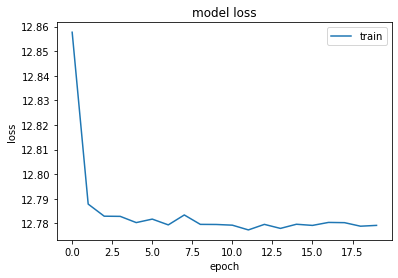

In [ ]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
import tensorflow_datasets as tfds
X_train_pred = model.predict(x_train_dataset)


In [ ]:
print(tf.shape(X_train_pred))

x_train_dataset = tf.reshape(list(x_train_dataset), (306752, 69))
print(tf.shape(x_train_dataset))

tf.Tensor([306752     69], shape=(2,), dtype=int32)
tf.Tensor([306752     69], shape=(2,), dtype=int32)


In [ ]:

mae_vector = get_error_term(X_train_pred, x_train_dataset, _rmse=False)

print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.09072533994913101
median error 0.0905056968331337
99Q: 0.14719959214329717
setting threshold on 0.14719959214329717 


In [ ]:
X_pred = model.predict(x_test_dataset)


In [ ]:
print(tf.shape(X_pred))

x_test_dataset = tf.reshape(list(x_test_dataset), (76672, 69))
print(tf.shape(x_test_dataset))

tf.Tensor([76672    69], shape=(2,), dtype=int32)
tf.Tensor([76672    69], shape=(2,), dtype=int32)


In [ ]:

mae_vector = get_error_term(X_pred, x_test_dataset, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.010121035058430717

In [ ]:
y_test = np.ones(len(x_test_dataset))
y_test[:len(x_test_dataset)] = 0

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     76672
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99     76672
   macro avg       0.50      0.49      0.50     76672
weighted avg       1.00      0.99      0.99     76672



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_encoded = get_encoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim).predict(x_test_dataset)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
nx, nsamples, ny = tf.shape(X_encoded)
print(tf.shape(X_encoded))
x_new = tf.reshape(X_encoded, (nsamples,nx*ny))
X_transform = pca.fit_transform(x_new)

tf.Tensor([    3 76672     2], shape=(3,), dtype=int32)


In [ ]:
import seaborn as sns

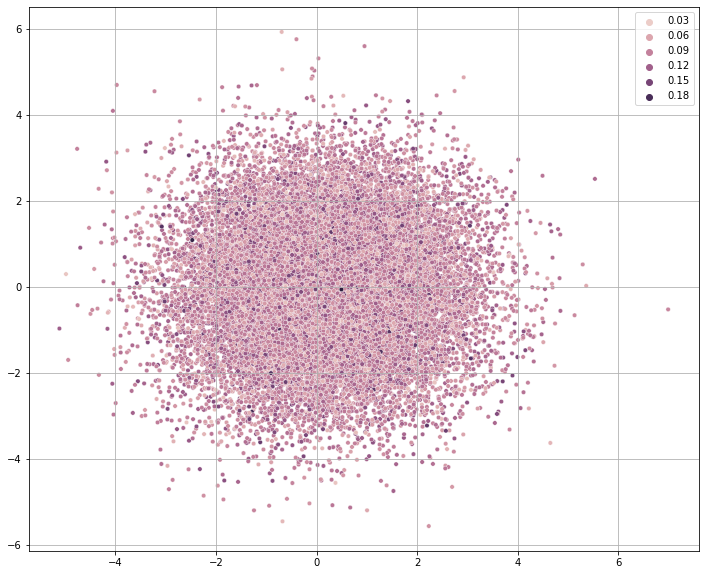

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

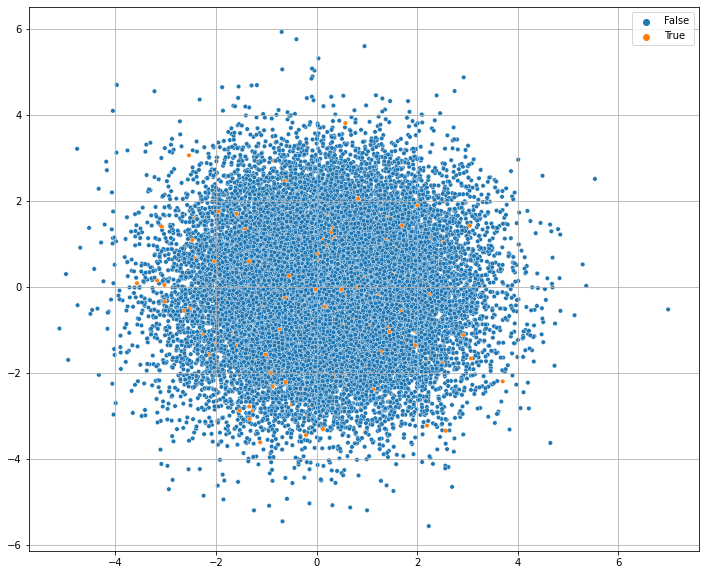

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

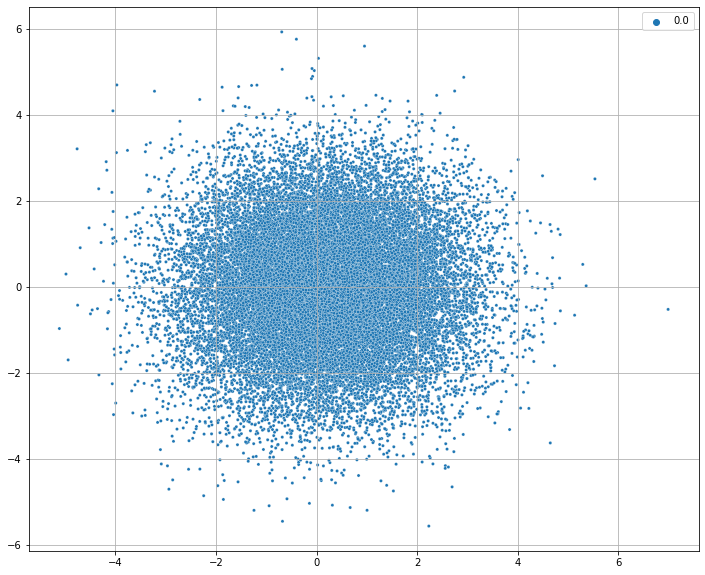

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()